In [1]:
!pip install praat-parselmouth
!pip install PyWavelets
!pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.0 MB/s eta 0:00:00


In [2]:
#Initiating the Env
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import librosa
import librosa.display
import os
from scipy.signal import hilbert, butter, lfilter
import parselmouth
import seaborn as sns
import pandas as pd
import pywt
from scipy.stats import skew, kurtosis

In [3]:
#Downloading the Data
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 11.11 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [4]:
#Downloading the data
digitLabel = list(range(10))  # 0-9
speakerName = ['george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler']
index = list(range(50))       # 0-49

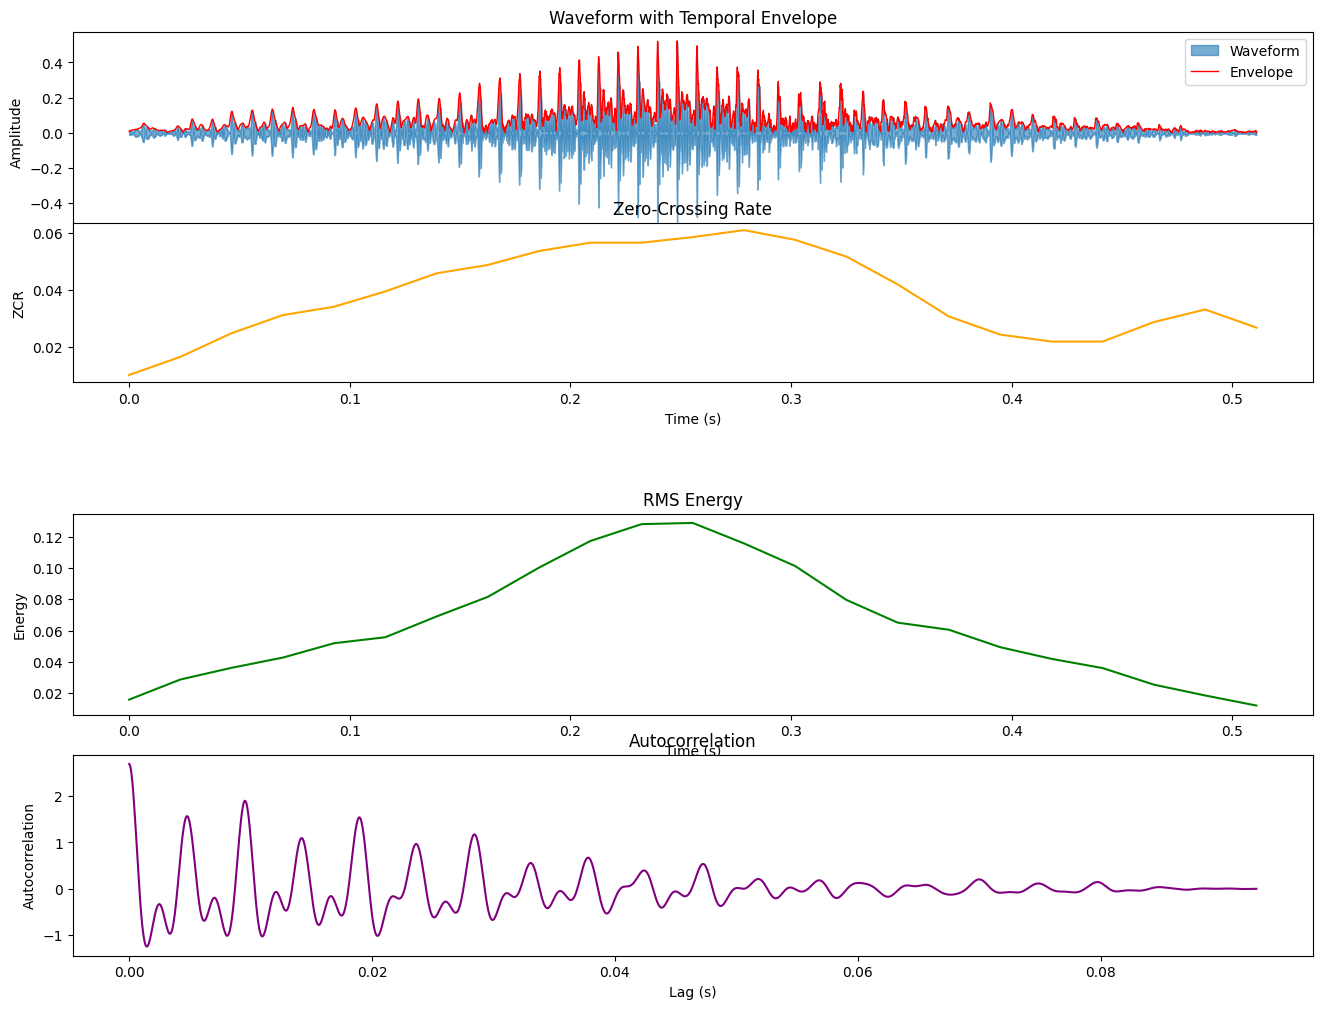

(array([0.01025391, 0.01660156, 0.02490234, 0.03125   , 0.03417969,
        0.03955078, 0.04589844, 0.04882812, 0.05371094, 0.05664062,
        0.05664062, 0.05859375, 0.06103516, 0.05761719, 0.05175781,
        0.04199219, 0.03076172, 0.02441406, 0.02197266, 0.02197266,
        0.02880859, 0.03320312, 0.02685547]),
 array([0.01597691, 0.02881526, 0.03626858, 0.04278533, 0.05194847,
        0.05576397, 0.06902758, 0.08150717, 0.1001771 , 0.11713846,
        0.12790358, 0.12867247, 0.11561472, 0.10114563, 0.07955262,
        0.06506731, 0.06053941, 0.04941592, 0.04199537, 0.03607788,
        0.02551648, 0.01862122, 0.01219463], dtype=float32),
 array([0.0103067 , 0.01103915, 0.0102618 , ..., 0.00980096, 0.00722102,
        0.00155877], dtype=float32),
 array([ 2.6939602e+00,  2.6816788e+00,  2.6458127e+00, ...,
        -7.7806786e-04, -5.1206583e-04, -2.2454235e-04], dtype=float32))

In [5]:
#1 Time-Domain
##1 Time Domain Analysis
#1.1  Extract statistical features (zero-crossing rate, energy, etc.)
def TD_Extract_Statistical_Features(IDigit,IName,Index):# Digit Inedx, Name Index, and Index

  Aux = f"{digitLabel[IDigit]}_{speakerName[IName]}_{index[Index]}" # Making the file name as variable to help excute it for all the recordings
  filename = f'/content/free-spoken-digit-dataset/recordings/{Aux}.wav' #Defining the filename
  y, sr = librosa.load(filename) # importing the sound

  zcr = librosa.feature.zero_crossing_rate(y)[0] # Zero-Crossing
  rms = librosa.feature.rms(y=y)[0]              # Root-Mean-Value

  # Temporal Envelope using Hilbert Transform
  analytic_signal = hilbert(y)
  envelope = np.abs(analytic_signal)

  # Autocorrelation
  autocorr_segment = y[:2048]
  autocorr = np.correlate(autocorr_segment, autocorr_segment, mode='full')
  autocorr = autocorr[autocorr.size // 2:]

  #Time axix
  frames = range(len(zcr))
  t = librosa.frames_to_time(frames, sr=sr)
  time = np.linspace(0, len(y)/sr, len(y))
  lags = np.arange(len(autocorr)) / sr  # lag time in seconds

  #Ploting the waveform and features
  plt.figure(figsize=(16,12))

  #Waveform
  plt.subplot(4, 1, 1)
  librosa.display.waveshow(y, sr=sr, alpha=0.6, label='Waveform')
  plt.plot(time, envelope, color='red', label='Envelope', linewidth=1)
  plt.title('Waveform with Temporal Envelope')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.legend()

  #ZCR
  plt.subplot(5, 1, 2)
  plt.plot(t, zcr, color='orange')
  plt.title('Zero-Crossing Rate')
  plt.ylabel('ZCR')
  plt.xlabel('Time (s)')

  #Root Mean Square
  plt.subplot(4, 1, 3)
  plt.plot(t, rms, color='green')
  plt.title('RMS Energy')
  plt.ylabel('Energy')
  plt.xlabel('Time (s)')

  #Temporal Envelope
  plt.subplot(4, 1, 4)
  plt.plot(lags, autocorr, color='purple')
  plt.title('Autocorrelation')
  plt.xlabel('Lag (s)')
  plt.ylabel('Autocorrelation')

  plt.show()


  return zcr, rms, envelope, autocorr

TD_Extract_Statistical_Features(1,1,1) #Visulizing sample

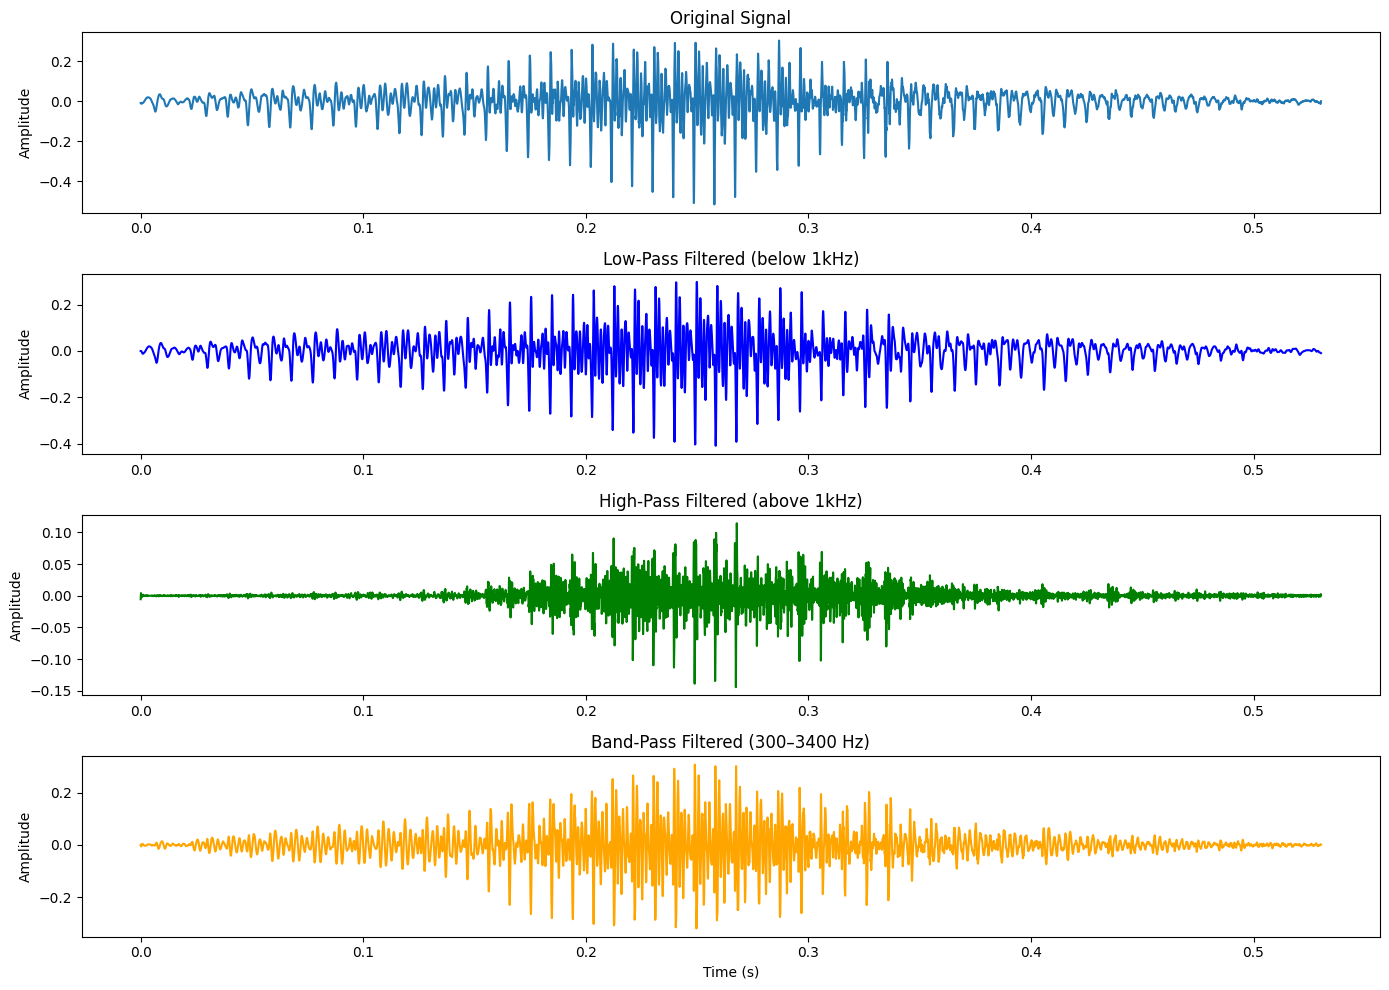

In [6]:
#1 Time Domain Analysis
#1.2  Implement basic filtering techniques


# Butterworth Filter Design Function
def butter_filter(data, cutoff, fs, btype='low', order=5):
  nyq = 0.5 * fs  # Nyquist frequency
  normal_cutoff = cutoff / nyq if isinstance(cutoff, (int, float)) else [c / nyq for c in cutoff]
  b, a = butter(order, normal_cutoff, btype=btype, analog=False)
  return lfilter(b, a, data)


Aux = f"{digitLabel[1]}_{speakerName[1]}_{index[1]}" # Making the file name as variable to help excute it for all the recordings
filename = f'/content/free-spoken-digit-dataset/recordings/{Aux}.wav' #Defining the filename
y, sr = librosa.load(filename) # importing the sound
t = np.linspace(0, len(y) / sr, len(y))



# Apply Filters
low_passed = butter_filter(y, cutoff=1000, fs=sr, btype='low')
high_passed = butter_filter(y, cutoff=1000, fs=sr, btype='high')
band_passed = butter_filter(y, cutoff=[300, 3400], fs=sr, btype='band')

# Plot original and filtered
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(t, y)
plt.title('Original Signal')
plt.ylabel('Amplitude')

plt.subplot(4, 1, 2)
plt.plot(t, low_passed, color='blue')
plt.title('Low-Pass Filtered (below 1kHz)')
plt.ylabel('Amplitude')

plt.subplot(4, 1, 3)
plt.plot(t, high_passed, color='green')
plt.title('High-Pass Filtered (above 1kHz)')
plt.ylabel('Amplitude')

plt.subplot(4, 1, 4)
plt.plot(t, band_passed, color='orange')
plt.title('Band-Pass Filtered (300–3400 Hz)')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

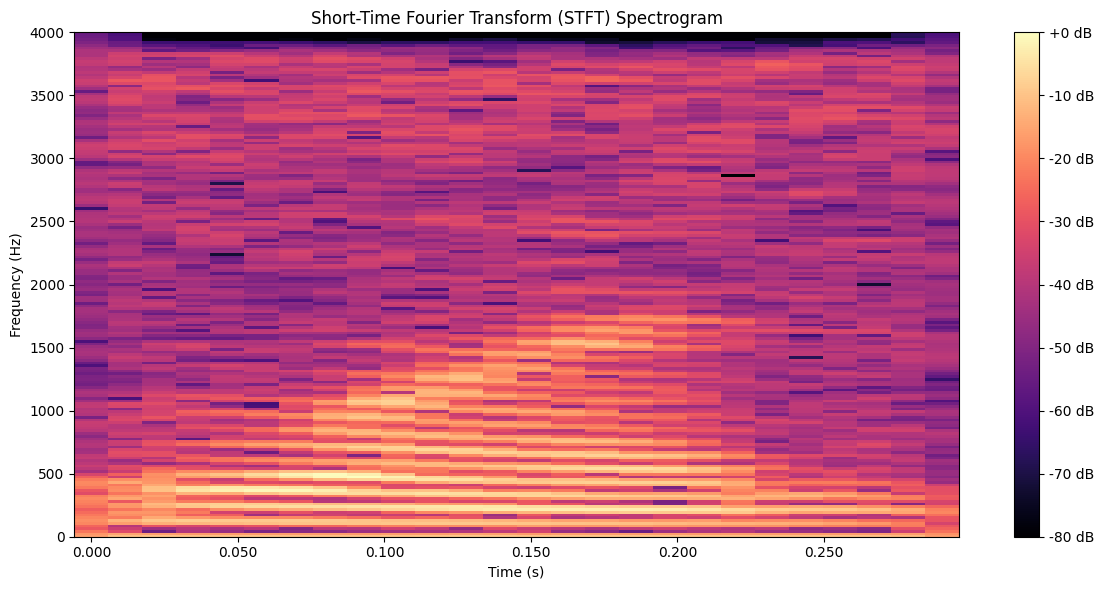

In [8]:
#2  Frequency-Domain Analysis
#2.1  Implement Short-Time Fourier Transform (STFT)


def FD_STFT(IDigit,IName,Index):# Digit Inedx, Name Index, and Index

  Aux = f"{digitLabel[IDigit]}_{speakerName[IName]}_{index[Index]}" # Making the file name as variable to help excute it for all the recordings
  filename = f'/content/free-spoken-digit-dataset/recordings/{Aux}.wav' #Defining the filename
  y, sr = librosa.load(filename)

  # Compute STFT
  D = librosa.stft(y, n_fft=1024, hop_length=256, window='hann')  # complex-valued
  S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)           # convert to dB

  # Plot the spectrogram
  plt.figure(figsize=(12, 6))
  librosa.display.specshow(S_db, sr=sr, hop_length=256, x_axis='time', y_axis='hz')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Short-Time Fourier Transform (STFT) Spectrogram')
  plt.xlabel('Time (s)')
  plt.ylabel('Frequency (Hz)')
  plt.ylim([0, 4000])  # Limit to 4kHz for speech range
  plt.tight_layout()
  plt.show()

  return S_db, y, sr

STFT = FD_STFT(IDigit=1,IName=3,Index=1) #Visulizing sample

In [9]:
#2  Frequency-Domain Analysis
#2.2 	Extract spectral features

def get_formants(y, sr):
    y = y * np.hamming(len(y))  # Apply Hamming window
    lpc = librosa.lpc(y, order=16)
    roots = np.roots(lpc)
    roots = [r for r in roots if np.imag(r) >= 0.01]
    angles = np.angle(roots)
    formants = sorted(angles * (sr / (2 * np.pi)))
    return formants[:3]  # Return first 3 formants

def FD_Featuers(IDigit,IName,Index):# Digit Inedx, Name Index, and Index

  Aux = f"{digitLabel[IDigit]}_{speakerName[IName]}_{index[Index]}" # Making the file name as variable to help excute it for all the recordings
  filename = f'/content/free-spoken-digit-dataset/recordings/{Aux}.wav' #Defining the filename
  y, sr = librosa.load(filename)

  # Mel-frequency cepstral coefficients (MFCCs)
  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

  # Spectral centroid and bandwidth
  centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
  bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

  #Formant frequencies


  formants = get_formants(y[:2048], sr)


  #Harmonic-to-noise ratio
  snd = parselmouth.Sound(y, sr)
  hnr = snd.to_harmonicity()
  hnr_val = hnr.values.T[0].mean()  # Average value of HNR

  print(f"MFCCs Shape: {mfccs.shape}")
  print(f"Spectral Centroid Mean: {np.mean(centroid):.2f} Hz")
  print(f"Spectral Bandwidth Mean: {np.mean(bandwidth):.2f} Hz")
  print(f"Formant Frequencies: {formants}")
  print(f"Harmonic-to-Noise Ratio (HNR): {hnr_val:.2f} dB")

  return mfccs, centroid, bandwidth, formants, hnr_val

Freq_Features=FD_Featuers(IDigit=1,IName=3,Index=1)

MFCCs Shape: (13, 13)
Spectral Centroid Mean: 1008.83 Hz
Spectral Bandwidth Mean: 1065.46 Hz
Formant Frequencies: [np.float64(371.5213746943471), np.float64(987.9851674169693), np.float64(2482.5270067335773)]
Harmonic-to-Noise Ratio (HNR): 6.54 dB


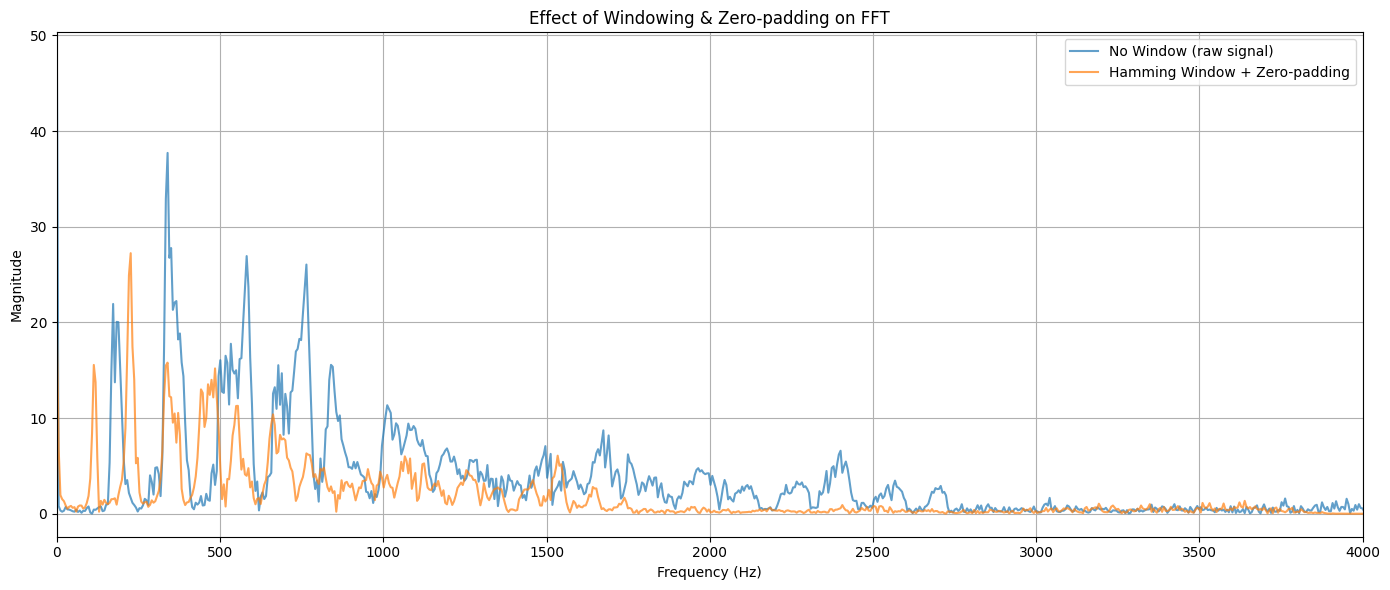

In [10]:
#2  Frequency-Domain Analysis
#2.3 	Address practical DFT issues (windowing, zero-padding)

def FD_Windowing_ZeroPadding(IDigit,IName,Index):# Digit Inedx, Name Index, and Index

  Aux = f"{digitLabel[IDigit]}_{speakerName[IName]}_{index[Index]}" # Making the file name as variable to help excute it for all the recordings
  filename = f'/content/free-spoken-digit-dataset/recordings/{Aux}.wav' #Defining the filename
  y, sr = librosa.load(filename)

  # Hamming Window
  windowed = y * np.hamming(len(y))


  # Zero-padding
  n_fft = 4096  # Power of 2, larger than signal length


  # FFT (no window, no padding)
  Y_plain = np.abs(np.fft.fft(y))[:n_fft//2]

  # FFT (windowed)
  Y_windowed = np.abs(np.fft.fft(windowed, n=n_fft))[:n_fft//2]

  # Frequency axis
  freqs = np.fft.fftfreq(n_fft, 1/sr)[:n_fft//2]

  # 🔍 Plot
  plt.figure(figsize=(14, 6))
  plt.plot(freqs, Y_plain, label='No Window (raw signal)', alpha=0.7)
  plt.plot(freqs, Y_windowed, label='Hamming Window + Zero-padding', alpha=0.7)
  plt.xlim(0, 4000)
  plt.title("Effect of Windowing & Zero-padding on FFT")
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Magnitude")
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()


FD_Windowing_ZeroPadding(IDigit=1,IName=3,Index=1)

#Observed:
# Raw FFT has more sharp and leaking spectrum
# Windowed + zero-padded FFT gives:
  # Smoother peaks
  # Better frequency resolution

In [11]:
#2  Frequency-Domain Analysis
#2.4  Consider formant analysis for digit recognition

def FD_Formant_Analysis(IDigit,IName,Index):# Digit Inedx, Name Index, and Index
  Aux = f"{digitLabel[IDigit]}_{speakerName[IName]}_{index[Index]}" # Making the file name as variable to help excute it for all the recordings
  filename = f'/content/free-spoken-digit-dataset/recordings/{Aux}.wav' #Defining the filename
  y, sr = librosa.load(filename)


  formants = get_formants(y, sr)
  F1 = formants[0]
  F2 = formants[1]
  F3 = formants[2]

  return F1,F2,F3

FD_Formant_Analysis(IDigit=1,IName=3,Index=1)

(np.float64(404.52880529120193),
 np.float64(713.2486513785844),
 np.float64(1442.3402529377993))

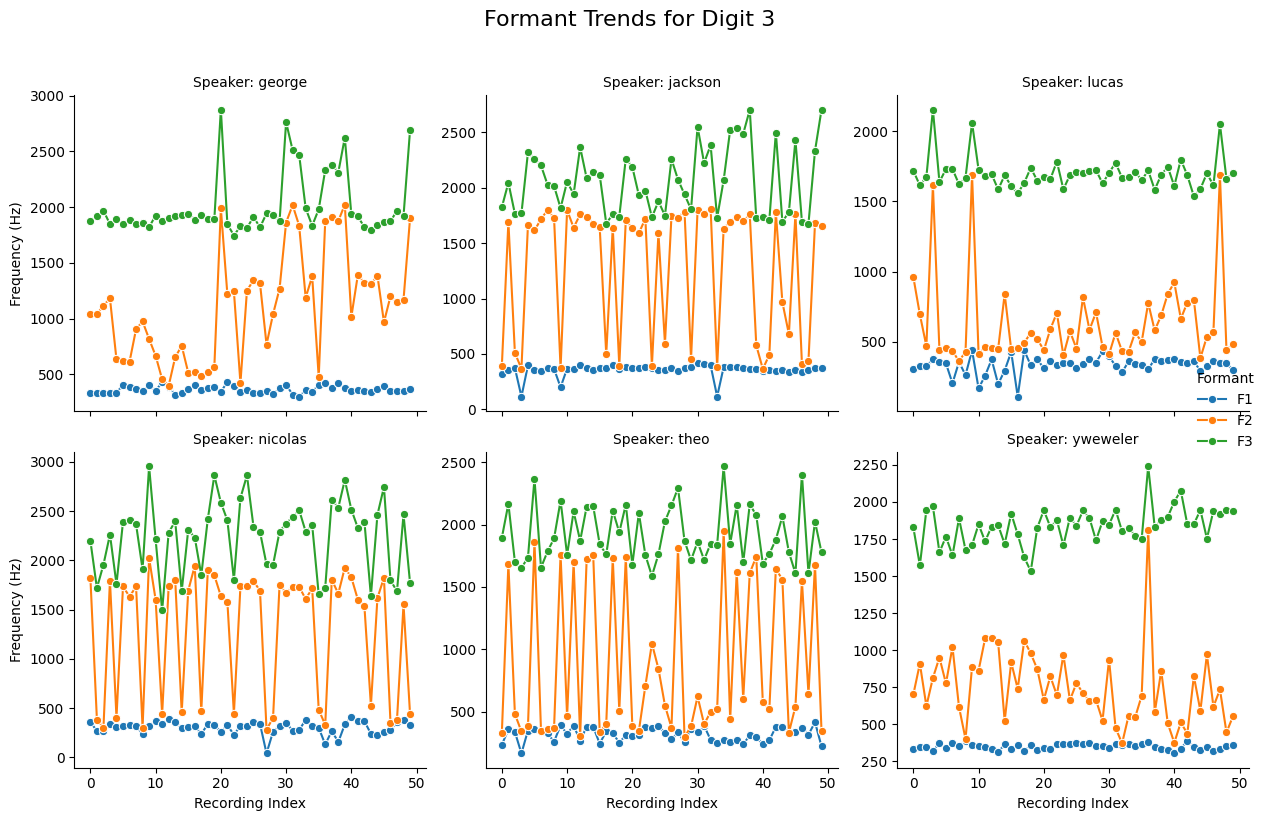

In [12]:
all_formant_data = []
for i_digit in range(len(digitLabel)):
    for i_speaker in range(len(speakerName)):
        for i_index in range(len(index)):
            f1, f2, f3 = FD_Formant_Analysis(IDigit=i_digit,IName=i_speaker,Index=i_index)
            if f1 is not None:
                all_formant_data.append({
                    'digit': digitLabel[i_digit],
                    'speaker': speakerName[i_speaker],
                    'index': index[i_index],
                    'F1': f1,
                    'F2': f2,
                    'F3': f3
                })

df = pd.DataFrame(all_formant_data)


def faceted_formant_plot_by_digit(df, selected_digit):
    # Filter by digit
    df_digit = df[df['digit'] == selected_digit]

    # Reshape for Seaborn
    df_melted = df_digit.melt(id_vars=['digit', 'speaker', 'index'],
                              value_vars=['F1', 'F2', 'F3'],
                              var_name='Formant',
                              value_name='Frequency')

    # Facet by speaker
    g = sns.FacetGrid(df_melted, col='speaker', hue='Formant', col_wrap=3, height=4, sharey=False)
    g.map(sns.lineplot, 'index', 'Frequency', marker='o')
    g.add_legend()
    g.set_titles("Speaker: {col_name}")
    g.set_axis_labels("Recording Index", "Frequency (Hz)")
    plt.suptitle(f"Formant Trends for Digit {selected_digit}", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage: plot for digit 3
faceted_formant_plot_by_digit(df, selected_digit=3)

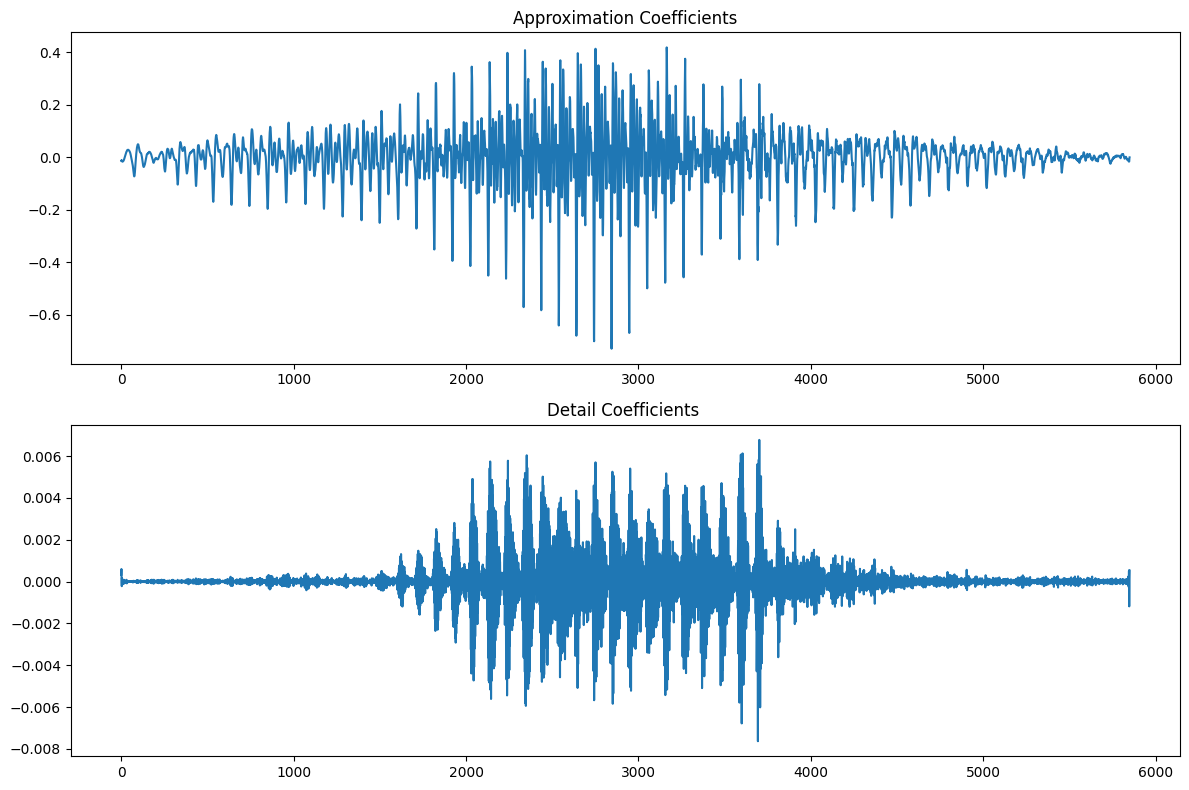

In [13]:
#3  Wavlet-Domain Analysis
#3.1 Implement discrete wavelet transform

def WD_Discrete_Wavelet_Transform (IDigit,IName,Index):# Digit Inedx, Name Index, and Index
  Aux = f"{digitLabel[1]}_{speakerName[1]}_{index[1]}" # Making the file name as variable to help excute it for all the recordings
  filename = f'/content/free-spoken-digit-dataset/recordings/{Aux}.wav' #Defining the filename
  y, sr = librosa.load(filename)


  coeffs = pywt.dwt(y,'db4')
  approx = coeffs[0]
  details = coeffs[1:]


  # Plot the coefficients
  plt.figure(figsize=(12, 8))
  plt.subplot(2, 1, 1)
  plt.plot(approx)
  plt.title(f'Approximation Coefficients')

  # Plot the coefficients
  for i, detail in enumerate(details):
      plt.subplot(2, 1, 2)
      plt.plot(detail)
      plt.title(f'Detail Coefficients ')

  plt.tight_layout()
  plt.show()

WD_Discrete_Wavelet_Transform(IDigit=1,IName=3,Index=1)

In [14]:
#3  Wavlet-Domain Analysis
#3.2	Extract wavelet-based features

def WD_Extract_Wavelet_Based_Features(IDigit,IName,Index):# Digit Inedx, Name Index, and Index
  Aux = f"{digitLabel[1]}_{speakerName[1]}_{index[1]}" # Making the file name as variable to help excute it for all the recordings
  filename = f'/content/free-spoken-digit-dataset/recordings/{Aux}.wav' #Defining the filename
  y, sr = librosa.load(filename)


  coeffs = pywt.dwt(y,'db4')
  approx = np.asarray(coeffs[0])
  details = np.asarray(coeffs[1])

  energy_total = np.sum(approx**2) + np.sum(details**2)


  features = {
        'approximation': features_from_coeffs(approx),
        'detail': features_from_coeffs(details),
        'relative_energy': {
            'cA': np.sum(approx**2) / energy_total,
            'cD': np.sum(details**2) / energy_total
        }
    }

  return features

def features_from_coeffs(c):

  energy = np.sum(c ** 2)
  probs = (c ** 2) / (np.sum(c ** 2) + 1e-12)
  entropy = -np.sum(probs * np.log2(probs + 1e-12))
  return {
      'energy': energy,
      'entropy': entropy,
      'mean': np.mean(c),
      'std': np.std(c),
      'skewness': skew(c),
      'kurtosis': kurtosis(c)
  }

WD_Extract_Wavelet_Based_Features(IDigit=1,IName=1,Index=1)

{'approximation': {'energy': np.float32(62.825607),
  'entropy': np.float32(10.309064),
  'mean': np.float32(-1.3748153e-05),
  'std': np.float32(0.10363117),
  'skewness': np.float64(-1.0836042165756226),
  'kurtosis': np.float32(6.9938574)},
 'detail': {'energy': np.float32(0.008548757),
  'entropy': np.float32(9.853144),
  'mean': np.float32(1.7237272e-07),
  'std': np.float32(0.0012088532),
  'skewness': np.float64(-0.028370141983032227),
  'kurtosis': np.float32(6.8447495)},
 'relative_energy': {'cA': np.float32(0.9998639),
  'cD': np.float32(0.00013605271)}}

In [15]:
#3  Wavlet-Domain Analysis
#3.3	Compare with STFT results
WD_Extract_Wavelet_Based_Features(IDigit=1,IName=1,Index=1)

{'approximation': {'energy': np.float32(62.825607),
  'entropy': np.float32(10.309064),
  'mean': np.float32(-1.3748153e-05),
  'std': np.float32(0.10363117),
  'skewness': np.float64(-1.0836042165756226),
  'kurtosis': np.float32(6.9938574)},
 'detail': {'energy': np.float32(0.008548757),
  'entropy': np.float32(9.853144),
  'mean': np.float32(1.7237272e-07),
  'std': np.float32(0.0012088532),
  'skewness': np.float64(-0.028370141983032227),
  'kurtosis': np.float32(6.8447495)},
 'relative_energy': {'cA': np.float32(0.9998639),
  'cD': np.float32(0.00013605271)}}

In [16]:
#3  Wavlet-Domain Analysis
#3.3	Compare with STFT results
a=FD_Featuers(IDigit=1,IName=1,Index=1)


MFCCs Shape: (13, 23)
Spectral Centroid Mean: 693.84 Hz
Spectral Bandwidth Mean: 710.54 Hz
Formant Frequencies: [np.float64(271.92050878717555), np.float64(531.7801375714997), np.float64(1831.2140748970182)]
Harmonic-to-Noise Ratio (HNR): -200.00 dB


In [18]:
digitLabel = list(range(10))  # 0–9
speakerName = ['george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler']
index = list(range(50))       # 0–49
DATA_PATH = "/content/free-spoken-digit-dataset/recordings"

#  Aggregation function
def aggregate_stats(x):
    return {
        'mean': np.mean(x),
        'std': np.std(x),
        'skew': skew(x),
        'kurtosis': kurtosis(x)
    }

#  Wavelet stats
def wavelet_stats(c):
    energy = np.sum(c ** 2)
    probs = (c ** 2) / (np.sum(c ** 2) + 1e-12)
    entropy = -np.sum(probs * np.log2(probs + 1e-12))
    return {
        'energy': energy,
        'entropy': entropy,
        'mean': np.mean(c),
        'std': np.std(c),
        'skew': skew(c),
        'kurtosis': kurtosis(c)
    }

#  Feature Extraction for One File
def extract_features(file_path, label):
    y, sr = librosa.load(file_path)

    # --- Time Features ---
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    rms = librosa.feature.rms(y=y)[0]
    envelope = np.abs(hilbert(y))
    autocorr = np.correlate(y[:2048], y[:2048], mode='full')[1024:]

    time_feats = {}
    for name, feat in zip(['zcr', 'rms', 'envelope', 'autocorr'], [zcr, rms, envelope, autocorr]):
        stats = aggregate_stats(feat)
        for stat_name, value in stats.items():
            time_feats[f'{name}_{stat_name}'] = value

    # --- Frequency Features ---
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_stats = {}
    for i in range(13):
        stats = aggregate_stats(mfccs[i])
        for stat_name, value in stats.items():
            mfcc_stats[f'mfcc{i+1}_{stat_name}'] = value

    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

    freq_feats = {}
    for name, feat in zip(['spectral_centroid', 'spectral_bandwidth'], [spectral_centroid, spectral_bandwidth]):
        stats = aggregate_stats(feat)
        for stat_name, value in stats.items():
            freq_feats[f'{name}_{stat_name}'] = value

    # Formants (basic 3 using LPC)
    y_win = y[:2048] * np.hamming(len(y[:2048]))
    lpc = librosa.lpc(y_win, order=16)
    roots = [r for r in np.roots(lpc) if np.imag(r) >= 0.01]
    formants = sorted(np.angle(roots) * (sr / (2 * np.pi)))[:3]
    for i, f in enumerate(formants):
        freq_feats[f'formant{i+1}'] = f if i < len(formants) else 0

    # Harmonic-to-noise ratio (HNR)
    snd = parselmouth.Sound(y, sr)
    hnr_val = snd.to_harmonicity().values.T[0].mean()
    freq_feats['hnr'] = hnr_val

    # --- Wavelet Features ---
    cA, cD = pywt.dwt(y, 'db4')
    wavelet_feats = {}
    for name, coeff in zip(['approx', 'detail'], [cA, cD]):
        stats = wavelet_stats(coeff)
        for stat_name, value in stats.items():
            wavelet_feats[f'{name}_{stat_name}'] = value

    wavelet_feats['relative_energy_cA'] = np.sum(cA**2) / (np.sum(cA**2) + np.sum(cD**2))
    wavelet_feats['relative_energy_cD'] = np.sum(cD**2) / (np.sum(cA**2) + np.sum(cD**2))

    # --- Combine all features ---
    features = {**time_feats, **mfcc_stats, **freq_feats, **wavelet_feats}
    features['label'] = label
    return features

# Loop over a subset (e.g., 3 speakers × 10 digits × 5 samples = 150 recordings)
features_list = []
for digit in range(10):
    for speaker in ['george', 'jackson', 'lucas']:  # Choose subset of speakers
        for idx in range(5):  # Few samples to start
            fname = f"{digit}_{speaker}_{idx}.wav"
            fpath = os.path.join(DATA_PATH, fname)
            if os.path.exists(fpath):
                feats = extract_features(fpath, digit)
                features_list.append(feats)

#  Build DataFrame
features_df = pd.DataFrame(features_list)
features_df.head()

,zcr_mean,zcr_std,zcr_skew,zcr_kurtosis,rms_mean,rms_std,rms_skew,rms_kurtosis,envelope_mean,envelope_std,...,approx_kurtosis,detail_energy,detail_entropy,detail_mean,detail_std,detail_skew,detail_kurtosis,relative_energy_cA,relative_energy_cD,label
0,0.060472,0.018810,0.139000,-1.110494,0.083725,0.021262,0.342208,-1.293562,0.110427,0.059999,...,0.159445,0.124186,8.882512,1.141439e-06,0.006145,-0.009968,8.457905,0.997607,0.002393,0
1,0.047119,0.015373,-0.101743,-0.336464,0.042974,0.024434,-0.054899,-1.507784,0.054244,0.045420,...,2.061960,0.018463,9.763884,-3.220257e-08,0.001683,0.001130,19.738340,0.999434,0.000566,0
2,0.051404,0.023863,0.583427,-0.714181,0.060192,0.039750,-0.051876,-1.628694,0.076744,0.068049,...,1.467910,0.060632,9.727706,-9.835385e-09,0.002872,-0.011484,15.110189,0.999216,0.000784,0
3,0.058503,0.030138,0.395496,-1.298462,0.063265,0.041061,0.058686,-1.507539,0.079243,0.071554,...,2.046083,0.186964,9.363133,-2.995644e-08,0.005204,-0.005979,15.624973,0.997623,0.002377,0
4,0.059530,0.032071,0.881843,-0.624418,0.063747,0.041999,-0.150186,-1.644599,0.079835,0.075176,...,2.192654,0.208198,9.063675,9.470360e-09,0.005910,-0.024537,16.751150,0.997094,0.002906,0


In [19]:
# Categorizing features into domains

time_features = [f for f in features_df.columns if f.startswith(('zcr', 'rms', 'envelope', 'autocorr'))]
freq_features = [f for f in features_df.columns if f.startswith(('spectral', 'mfcc'))]
wavelet_features = [f for f in features_df.columns if f.startswith(('approximation', 'detail', 'wavelet_energy'))]
all_features = time_features + freq_features + wavelet_features



📊 Results for: Time-Domain Features
Accuracy: 0.4889
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.50      0.25      0.33         8
           2       0.75      0.60      0.67         5
           3       0.43      0.75      0.55         4
           4       0.71      1.00      0.83         5
           5       0.00      0.00      0.00         5
           6       0.33      1.00      0.50         1
           7       0.75      1.00      0.86         3
           8       0.33      0.50      0.40         4
           9       0.20      0.20      0.20         5

    accuracy                           0.49        45
   macro avg       0.47      0.57      0.48        45
weighted avg       0.47      0.49      0.46        45



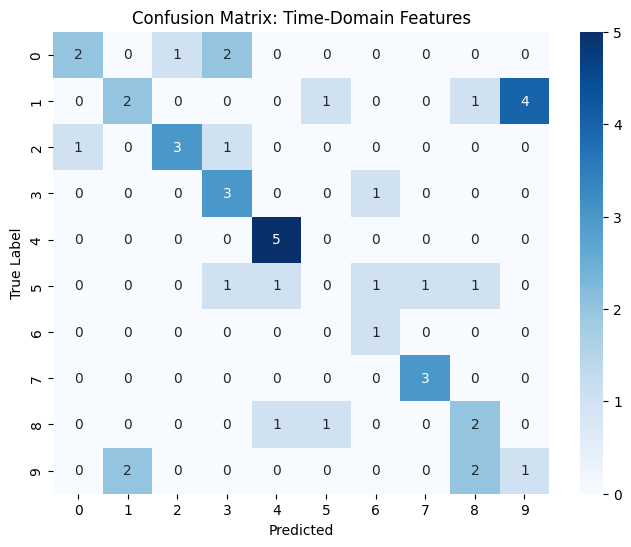


📊 Results for: Frequency-Domain Features
Accuracy: 0.9111
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.88      0.93         8
           2       1.00      1.00      1.00         5
           3       0.80      1.00      0.89         4
           4       0.83      1.00      0.91         5
           5       1.00      0.80      0.89         5
           6       0.50      1.00      0.67         1
           7       0.75      1.00      0.86         3
           8       1.00      0.50      0.67         4
           9       1.00      1.00      1.00         5

    accuracy                           0.91        45
   macro avg       0.89      0.92      0.88        45
weighted avg       0.94      0.91      0.91        45



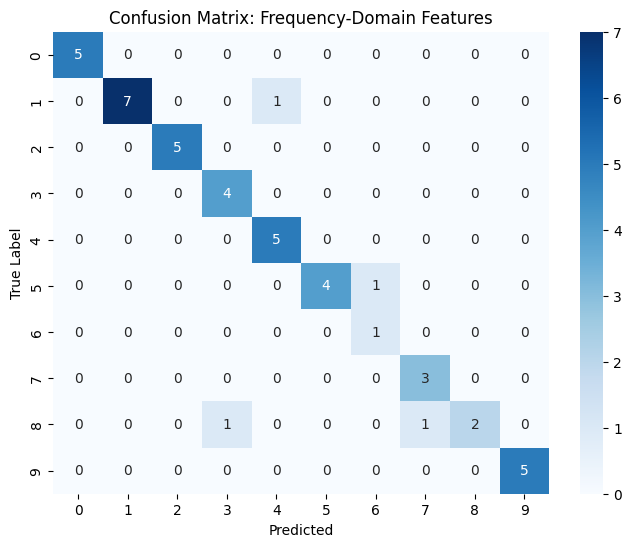


📊 Results for: Wavelet-Domain Features
Accuracy: 0.5111
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       1.00      0.50      0.67         8
           2       0.50      0.40      0.44         5
           3       0.33      0.25      0.29         4
           4       1.00      0.80      0.89         5
           5       0.60      0.60      0.60         5
           6       0.33      1.00      0.50         1
           7       0.33      0.67      0.44         3
           8       0.25      0.50      0.33         4
           9       0.25      0.20      0.22         5

    accuracy                           0.51        45
   macro avg       0.53      0.55      0.51        45
weighted avg       0.60      0.51      0.53        45



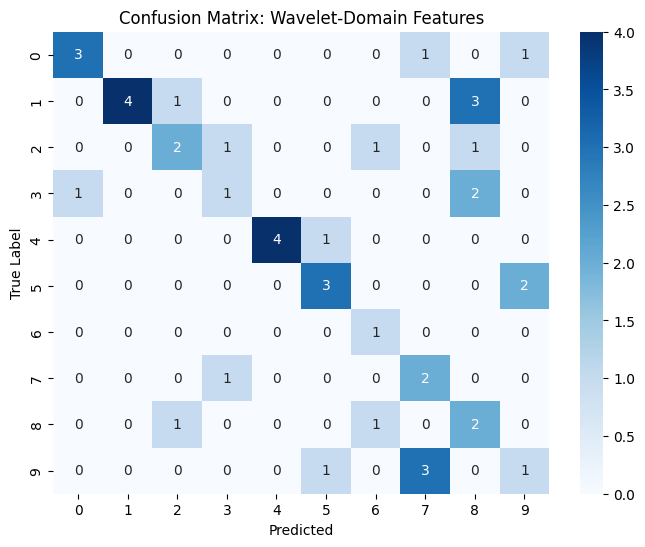


📊 Results for: Combined All Features
Accuracy: 0.9111
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.75      0.86         8
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         5
           5       1.00      0.60      0.75         5
           6       0.50      1.00      0.67         1
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         4
           9       0.71      1.00      0.83         5

    accuracy                           0.91        45
   macro avg       0.90      0.93      0.90        45
weighted avg       0.94      0.91      0.91        45



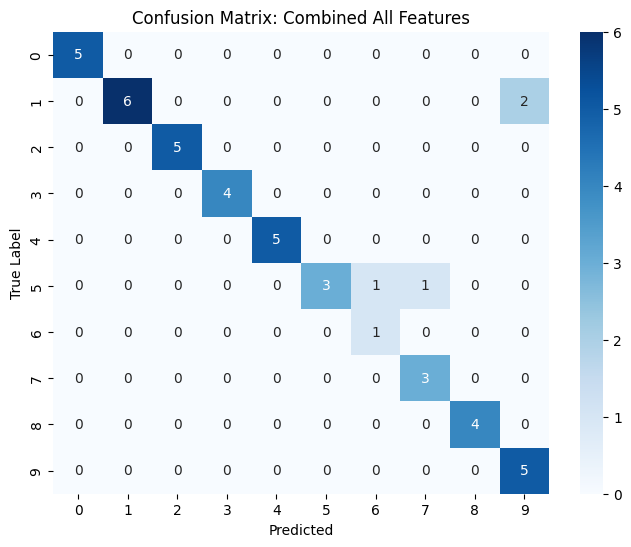

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

def classify_and_evaluate(X, y, feature_set_name):
    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Normalize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    print(f"\n📊 Results for: {feature_set_name}")
    print("Accuracy:", round(acc, 4))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {feature_set_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.show()

    return acc

y = features_df['label']

acc_time = classify_and_evaluate(features_df[time_features], y, "Time-Domain Features")
acc_freq = classify_and_evaluate(features_df[freq_features], y, "Frequency-Domain Features")
acc_wavelet = classify_and_evaluate(features_df[wavelet_features], y, "Wavelet-Domain Features")
acc_all = classify_and_evaluate(features_df[all_features], y, "Combined All Features")


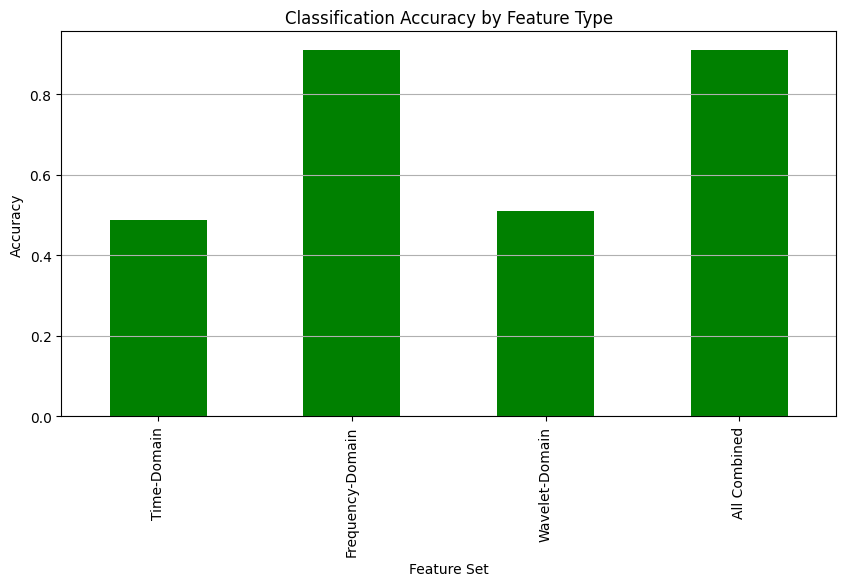

In [22]:
results = pd.DataFrame({
    'Feature Set': ['Time-Domain', 'Frequency-Domain', 'Wavelet-Domain', 'All Combined'],
    'Accuracy': [acc_time, acc_freq, acc_wavelet, acc_all]
})

results.set_index('Feature Set').plot(kind='bar', figsize=(10, 5), color='green', legend=False)
plt.title("Classification Accuracy by Feature Type")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()
